In [31]:
!pip install tensorflow

In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS=3

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Food Classification",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 3138 files belonging to 10 classes.


In [36]:
class_names = dataset.class_names
class_names

['butter_naan',
 'chole_bhature',
 'fried_rice',
 'jalebi',
 'kadai_paneer',
 'masala_dosa',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'samosa']

In [37]:
len(dataset)

99

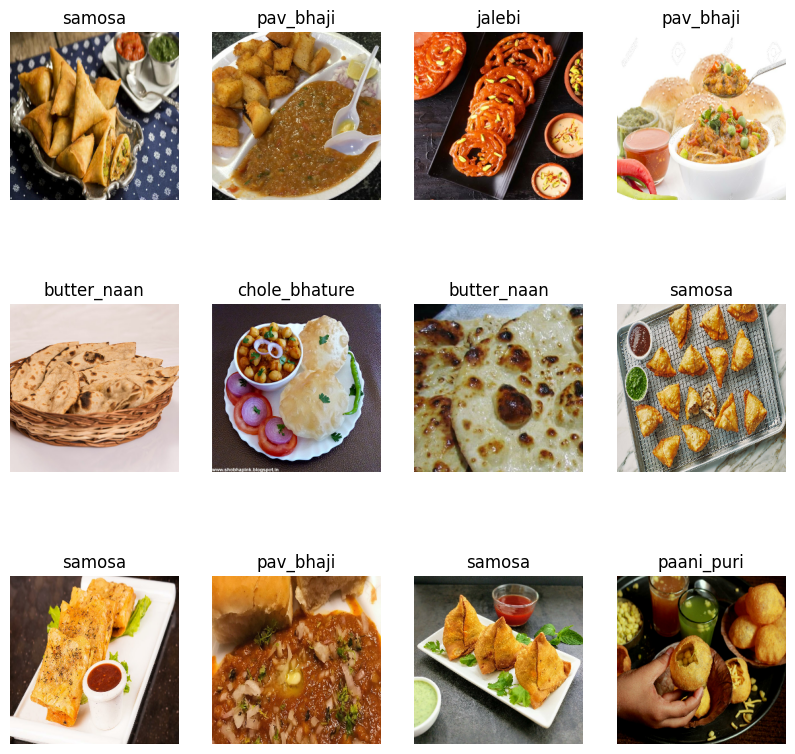

In [38]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [39]:
train_size = 0.8
len(dataset)*0.8

79.2

In [40]:
train_ds = dataset.take(79) # first 54
len(train_ds)

79

In [41]:
test = dataset.skip(79)  # skip first 54 batches
len(test)

20

In [42]:
valid_ds = test.take(10)
len(valid_ds)
test_ds = test.skip(10)
len(test_ds)

10

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [45]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [47]:
n_classes = len(class_names)
n_classes

10

In [46]:
input_shape = (32,256,256,3)

base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(256,256,3)
                     )

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
        base_model,
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])
model.build(input_shape = input_shape)

In [48]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_1019 (  (32, 6, 6, 1536)          10752     
 BatchNormalization)                                             
                                                                 
 global_average_pooling2d_4  (32, 1536)                0         
  (GlobalAveragePooling2D)                                       
                                                      

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=32,
    verbose=1,
    validation_data=valid_ds
)

Epoch 1/5
79/79 [==============================] - 22s 278ms/step - loss: 0.4184 - accuracy: 0.8699 - val_loss: 0.5284 - val_accuracy: 0.8375
Epoch 2/5
79/79 [==============================] - 22s 276ms/step - loss: 0.3645 - accuracy: 0.8869 - val_loss: 0.5682 - val_accuracy: 0.8406
Epoch 3/5
79/79 [==============================] - 21s 266ms/step - loss: 0.3550 - accuracy: 0.8833 - val_loss: 0.5656 - val_accuracy: 0.8313
Epoch 4/5
79/79 [==============================] - 21s 268ms/step - loss: 0.3160 - accuracy: 0.8972 - val_loss: 0.5693 - val_accuracy: 0.8375
Epoch 5/5
79/79 [==============================] - 21s 272ms/step - loss: 0.3204 - accuracy: 0.8995 - val_loss: 0.5266 - val_accuracy: 0.8469


In [52]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 66s 336ms/step - loss: 0.4588 - accuracy: 0.8724


In [53]:
scores

[0.4588145315647125, 0.8724138140678406]

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

1/1 [==============================] - 5s 5s/step
chole_bhature


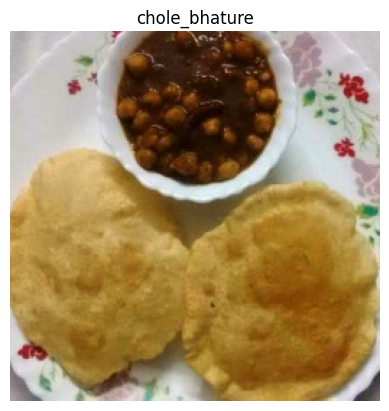

In [55]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):

    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')
    batch_pred = model.predict(image_batch)
    print(class_names[np.argmax(batch_pred[0])])

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step
Actual: pakode
Predicted: samosa
Confidence: 89.99
1/1 [==============================] - 0s 76ms/step
Actual: masala_dosa
Predicted: masala_dosa
Confidence: 99.7
1/1 [==============================] - 0s 83ms/step
Actual: kadai_paneer
Predicted: kadai_paneer
Confidence: 100.0
1/1 [==============================] - 0s 71ms/step
Actual: fried_rice
Predicted: fried_rice
Confidence: 99.89
1/1 [==============================] - 0s 65ms/step
Actual: pakode
Predicted: pakode
Confidence: 99.72
1/1 [==============================] - 0s 94ms/step
Actual: masala_dosa
Predicted: masala_dosa
Confidence: 100.0
1/1 [==============================] - 0s 82ms/step
Actual: fried_rice
Predicted: fried_rice
Confidence: 99.69
1/1 [==============================] - 0s 73ms/step
Actual: pakode
Predicted: pakode
Confidence: 78.84
1/1 [==============================] - 0s 72ms/step
Actual: kadai_paneer
Predicted: jalebi
Confidence: 95.82


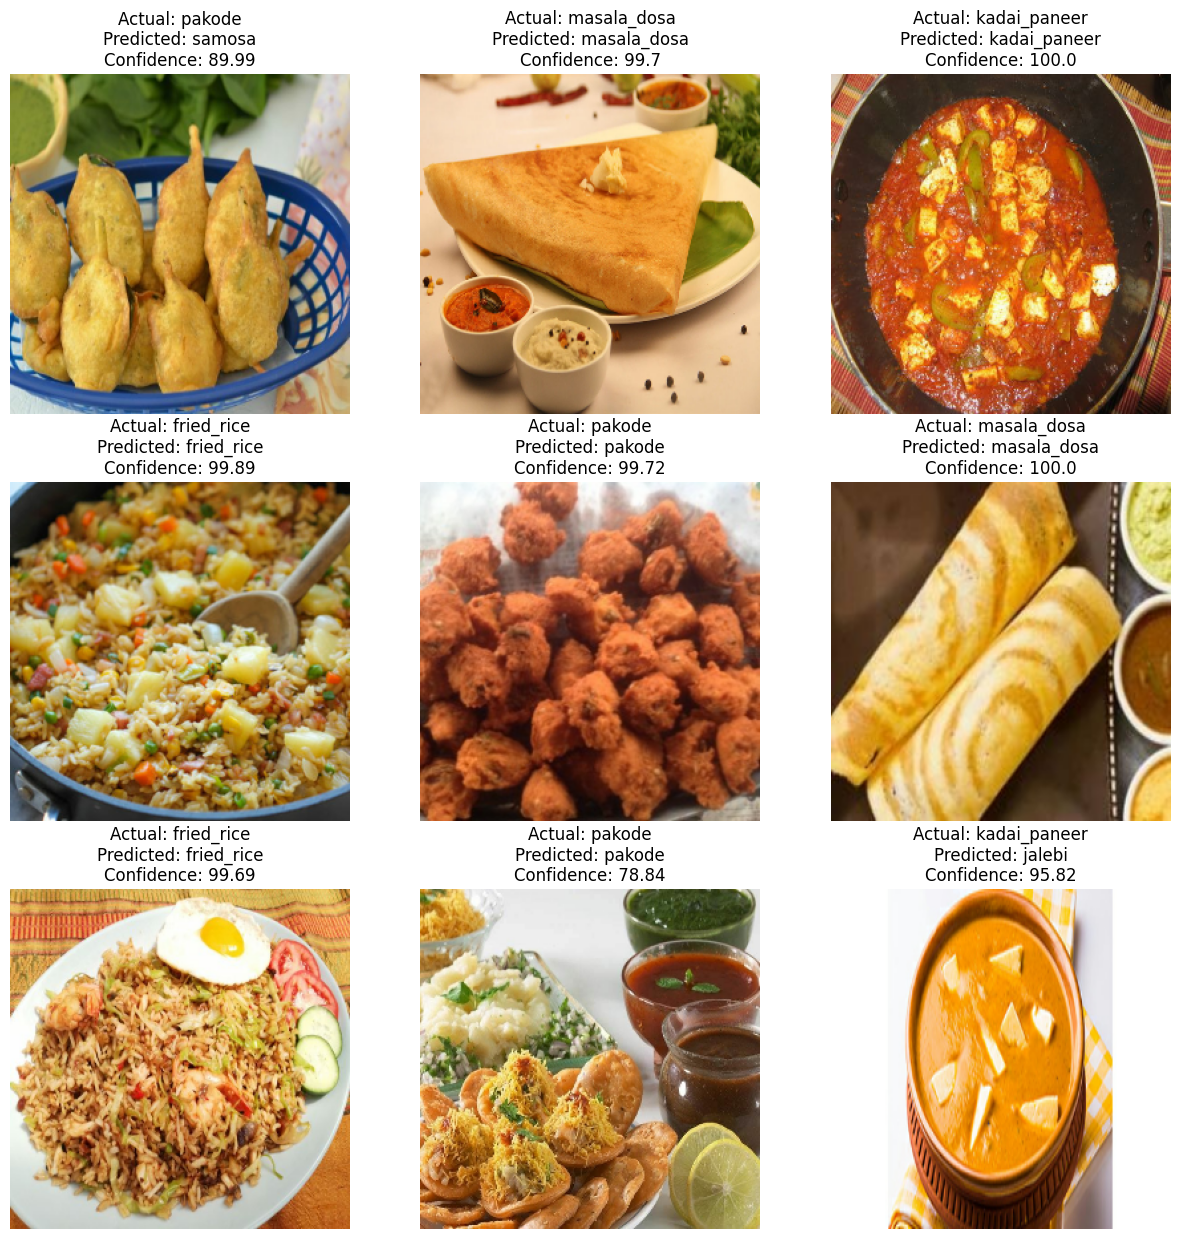

In [58]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        print(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}")
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
